<a href="https://colab.research.google.com/github/HimajaChaluvadi/Threads_Sentiment_Analysis/blob/main/insta_threads_sentiment_analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


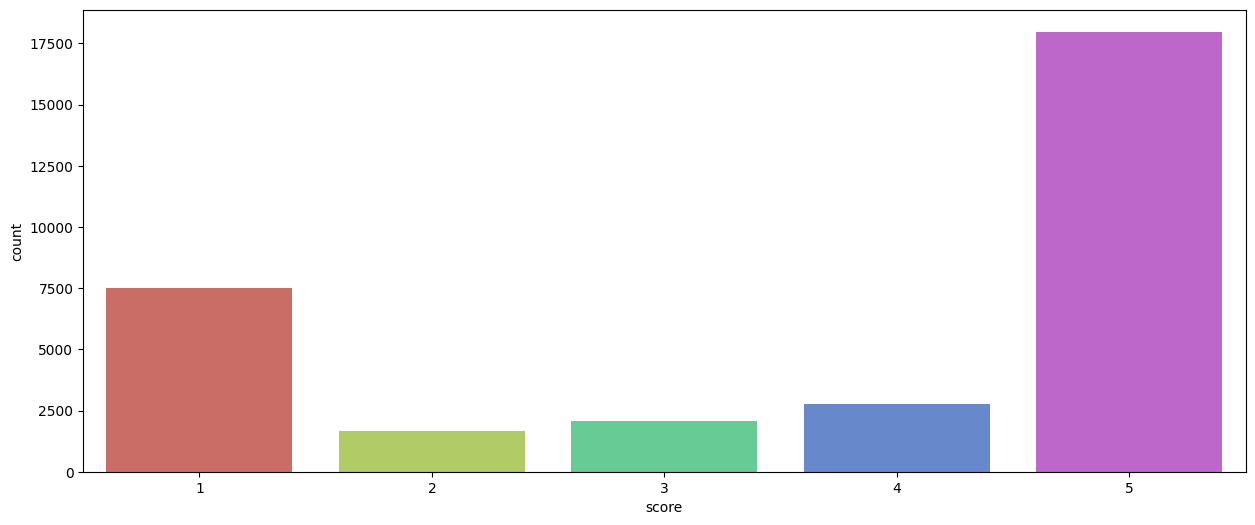

start date:  2024-03-21 17:41:38
end date:  2024-12-09 13:24:51


Accuracy: 0.753125
Classification Report:
              precision    recall  f1-score   support

          -1       0.77      0.68      0.72      1837
           0       0.06      0.08      0.07       417
           1       0.83      0.85      0.84      4146

    accuracy                           0.75      6400
   macro avg       0.55      0.54      0.55      6400
weighted avg       0.76      0.75      0.76      6400



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
import nltk
import spacy
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import pickle

# Setup and warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')

# Load the dataset
df = pd.read_csv("/content/threads_comments.csv")

# Check and clean dataset
df.head()
df.columns
df.duplicated().sum()
df = df.drop_duplicates()
df.isnull().sum()
df.nunique()

# Plotting the distribution of scores
plt.figure(figsize=(15, 6))
sns.countplot(x=df['score'], data=df, palette='hls')
plt.show()

# Convert 'at' column to datetime
df['at'] = pd.to_datetime(df['at'])

# Create a copy and set 'at' as the index
df1 = df.copy()
df1.set_index('at', inplace=True)

# Define date range for plotting
start_date = df1.index.min()
end_date = df1.index.max()
print("start date: ", start_date)
print("end date: ", end_date)

week_delta = pd.Timedelta(days=6)
current_date = start_date

# Loop through the data by weeks and plot weekly review counts
while current_date <= end_date:
    start_week = current_date
    end_week = current_date + week_delta
    current_week_data = df1[(df1.index >= start_week) & (df1.index < end_week)]
    weekly_counts = current_week_data.resample('D').size()
    fig = px.bar(weekly_counts, x=weekly_counts.index, y=weekly_counts.values,
                 labels={'x': 'Date', 'y': 'Number of Reviews'},
                 title=f'Reviews for Week {start_week.strftime("%Y-%m-%d")} to {end_week.strftime("%Y-%m-%d")}')
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()
    current_date += week_delta

# Plot daily review counts
daily_counts = df1.resample('D').size()

fig = go.Figure()
fig.add_trace(go.Bar(x=daily_counts.index, y=daily_counts.values,
                     marker_color='skyblue'))
fig.update_layout(title='Number of Reviews Day-wise',
                  xaxis_title='Date',
                  yaxis_title='Number of Reviews',
                  xaxis_tickangle=-45)
fig.show()

# Sentiment analysis setup
df['score'] = df['score'].map({1: -1, 2: -1, 3: 0, 4: 1, 5: 1})  # Mapping scores to sentiment values
df_new = df[['content', 'score']]

# Sentiment distribution plot
fig = go.Figure(data=[go.Bar(x=df_new['score'].value_counts().index, y=df_new['score'].value_counts())])
fig.update_layout(title='Sentiment Distribution', xaxis_title="Sentiment", yaxis_title="Count")
fig.show()

# Text preprocessing functions
def clean_text(text):
    if isinstance(text, str):  # Check if the value is a string
        text = re.sub('\[.*\]', '', text).strip()
        text = re.sub('\S*\d\S*\s*', '', text).strip()
        return text
    else:
        return ''  # Return an empty string if the value is not a string


def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def tokenization(text):
    return re.split(' ', text)

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    return " ".join([i for i in text if i not in stopwords])

def lemmatizer(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.text not in nlp.Defaults.stop_words])

# Apply text preprocessing
df_new['content'] = df_new['content'].apply(lambda x: clean_text(x))
df_new['content'] = df_new['content'].apply(lambda x: remove_punctuation(x))
df_new['content'] = df_new['content'].apply(lambda x: tokenization(x))
df_new['content'] = df_new['content'].apply(lambda x: remove_stopwords(x))
df_new['content'] = df_new['content'].apply(lambda x: lemmatizer(x))

# Feature extraction using TF-IDF
tf1 = TfidfVectorizer()
data_vec = tf1.fit_transform(df_new['content'])

# Saving the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as model_file:
    pickle.dump(tf1, model_file)

# Sentiment analysis model setup
y = df_new['score'].values
X_train, X_test, y_train, y_test = train_test_split(data_vec, y, test_size=0.2, stratify=y, random_state=42)

# Balancing the data using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Model training
sv = SVC()
sv.fit(X_balanced, y_balanced)

# Saving the model
model_filename = 'svm_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(sv, model_file)

# Evaluate the model
y_pred = sv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')